In [98]:
import numpy as np
import matplotlib.pyplot as plt
import mapping

## Choose spectral density

As an example we use a sub-ohmic spectral density:

In [99]:
alpha = 1
s = 0.5
omega_c = 1
domain = [0.0, 10*omega_c]
J = lambda x: alpha * omega_c * (x / omega_c) ** s * np.exp(-x / omega_c)

Choose the number of coefficients to be computed:

In [100]:
nof_coefficients = 50

Accuracy parameter for the chain calculations. If set None, we use nof_coefficients discretization points for the chain mapping

In [101]:
ncap = 1000

Set parameters for the chain mapping. Specifically the type of discretization and the type of chain mapping.

In [102]:
chain_params = {'disc_type': 'sp_quad', 'mapping_type': 'sp_hes', 'interval_type': 'lin', 'epsabs': 1e-12, 'epsrel': 1e-12}

Set parameters for the direct star mapping.  We may impose and order on the coefficients by setting the sort_by parameter to a valid string (e.g. 'gamma_a' or 'xi_abs_d')

In [103]:
star_params = {'disc_type': 'sp_quad', 'mapping_type': 'sp_hes', 'interval_type': 'lin', 'epsabs': 1e-12, 'epsrel': 1e-12,
              'sort_by': None, 'orthpol_ncap': 10000}

### Plot the chosen spectral function

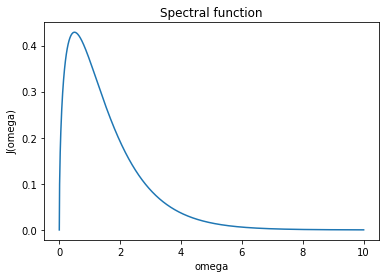

In [104]:
grid = np.linspace(domain[0], domain[1], num=1000)
plt.plot(grid, J(grid))
plt.ylabel('J(omega)')
plt.xlabel('omega')
plt.title('Spectral function')
plt.show()

## Chain mapping

### Via `mapping.chain.get`

In [105]:
%%time
c0, omega, t, info = mapping.chain.get(J, domain, nof_coefficients=nof_coefficients, ncap=ncap, **chain_params)

Wall time: 2.17 s


The info dict contains information about the residual of the tridiagonalization, which can be accessed via:

In [106]:
print(info['res'])

(7.88289634899701e-15, 2.1094237467877974e-15)


The tuple consists of: (Frombenius norm of `(V.T @ V - id)`, `max(|V.T @ V - id|`)
where V is the transformation matrix of the tridiagonalization for the matrix `A` (`T = V.T A V`)

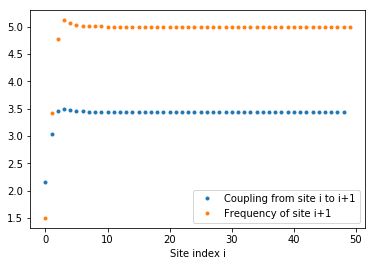

In [107]:
plt.plot([c0] + t, '.', label = 'Coupling from site i to i+1')
plt.plot(omega, '.', label = 'Frequency of site i+1')
plt.xlabel('Site index i')
plt.legend()
plt.show()

### Via `mapping.chain.get_bsdo`

This function directly returns the chain bsdo coefficients calculated via py-orthpol

In [108]:
%%time
c0_bsdo, omega_bsdo, t_bsdo = mapping.chain.get_bsdo(J, domain, nof_coefficients=nof_coefficients, orthpol_ncap=10000)

Wall time: 2.9 s


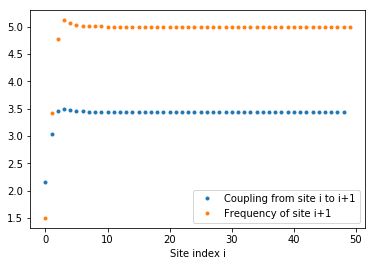

In [109]:
plt.plot([c0_bsdo] + t_bsdo, '.', label = 'Coupling from site i to i+1')
plt.plot(omega_bsdo, '.', label = 'Frequency of site i+1')
plt.xlabel('Site index i')
plt.legend()
plt.show()

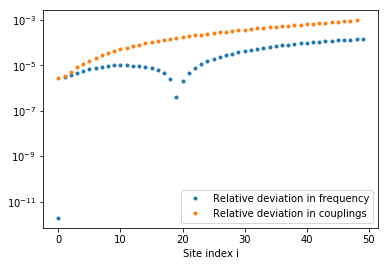

In [110]:
plt.plot(np.abs((omega-omega_bsdo)/omega_bsdo), '.', label = 'Relative deviation in frequency')
plt.plot(np.abs((t - t_bsdo)/t_bsdo), '.', label = 'Relative deviation in couplings')
plt.yscale('log')
plt.xlabel('Site index i')
plt.legend()
plt.show()

## Computing coefficients for the discrete star

### Directly, via `mapping.star.get`

This means direct discretization of the bath

In [111]:
%%time
gamma, xi = mapping.star.get(J, domain, nof_coefficients=nof_coefficients, **star_params)

Wall time: 33.9 ms


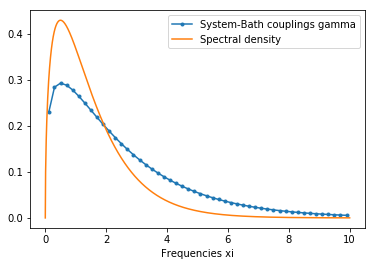

In [112]:
plt.plot(xi, gamma, '.-', label='System-Bath couplings gamma')
grid = np.linspace(domain[0], domain[1], num=1000)
plt.plot(grid, J(grid), label='Spectral density')
plt.xlabel('Frequencies xi')
plt.legend()
plt.show()

### By converting 
the previously calculated chain coefficients `c0, omega, t` into star coefficients using 
`mapping.convert_chain_to_star`:

In [113]:
%%time
gamma_conv, xi_conv, info = mapping.convert_chain_to_star(c0, omega, t, sort_by=star_params['sort_by'])

Wall time: 18.1 s


The info dict would contain the transformation matrix, if selected in the function call (default is `False`)

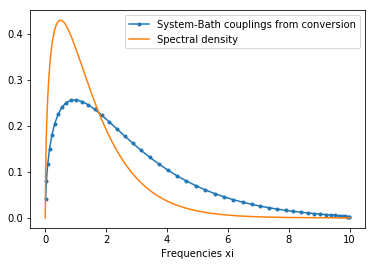

In [114]:
plt.plot(xi_conv, gamma_conv, '.-', label='System-Bath couplings from conversion')
grid = np.linspace(domain[0], domain[1], num=1000)
plt.plot(grid, J(grid), label='Spectral density')
plt.xlabel('Frequencies xi')
plt.legend()
plt.show()

Those converted coefficients need not be the same as the ones from `mapping.star.get`, if the accuracy parameter ncap was chosen differently from `None`

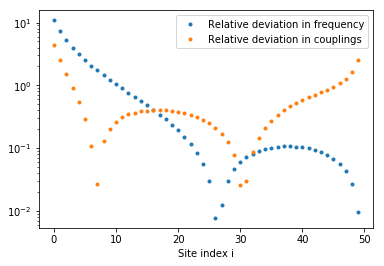

In [115]:
plt.plot(np.abs((xi - xi_conv)/xi_conv), '.', label = 'Relative deviation in frequency')
plt.plot(np.abs((gamma - gamma_conv)/gamma_conv), '.', label = 'Relative deviation in couplings')
plt.xlabel('Site index i')
plt.yscale('log')
plt.legend()
plt.show()

### Via `mapping.star.get_bsdo`

This function directly returns the star coefficients calculated via py-orthpol and diagonalization

In [116]:
%%time
gamma_bsdo, xi_bsdo, info = mapping.star.get_bsdo(J, domain, nof_coefficients, orthpol_ncap=10000, sort_by=star_params['sort_by'])

Wall time: 20.9 s


Again, the info object contains the transformation matrix, if selected in the function call (default is `False`)

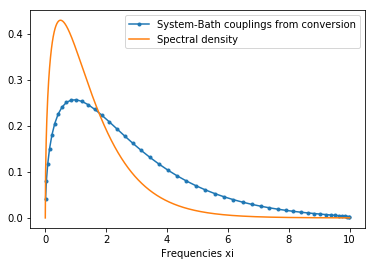

In [117]:
plt.plot(xi_bsdo, gamma_bsdo, '.-', label='System-Bath couplings from conversion')
grid = np.linspace(domain[0], domain[1], num=1000)
plt.plot(grid, J(grid), label='Spectral density')
plt.xlabel('Frequencies xi')
plt.legend()
plt.show()

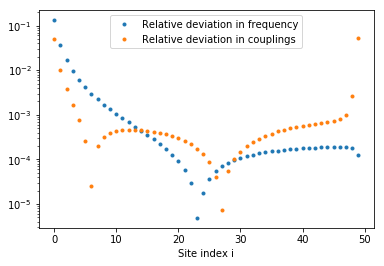

In [118]:
plt.plot(np.abs((xi_bsdo - xi_conv)/xi_bsdo), '.', label = 'Relative deviation in frequency')
plt.plot(np.abs((gamma_bsdo - gamma_conv)/gamma_bsdo), '.', label = 'Relative deviation in couplings')
plt.xlabel('Site index i')
plt.yscale('log')
plt.legend()
plt.show()